In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

In [2]:
metadata_with_images = pd.read_csv('HAM10000_metadata_with_image_data.csv')

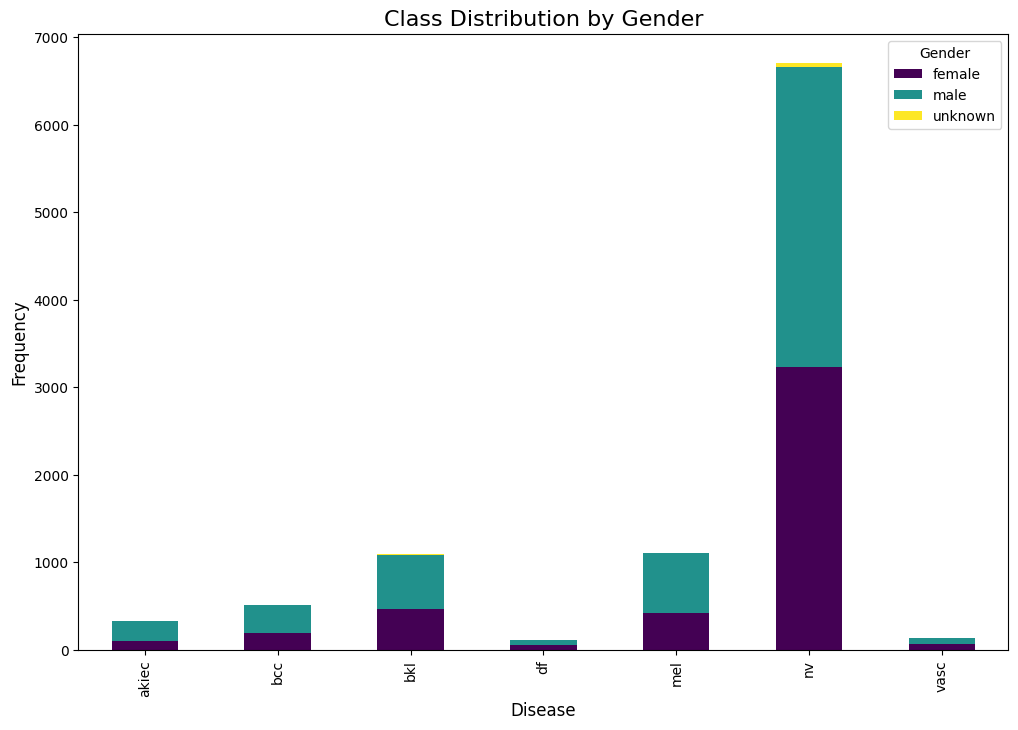

In [3]:
class_gender_counts = metadata_with_images.groupby(['dx', 'sex']).size().unstack()
class_gender_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Class Distribution by Gender', size=16)
plt.legend(title='Gender')
plt.show()

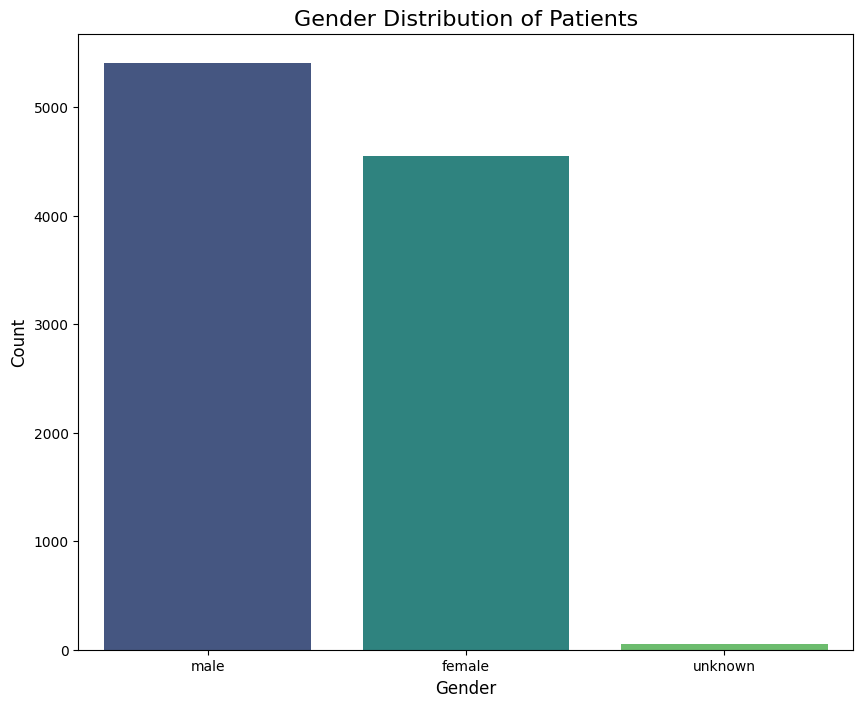

In [4]:
gender_counts = metadata_with_images['sex'].value_counts()

plt.figure(figsize=(10, 8))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='viridis')
plt.xlabel('Gender', size=12)
plt.ylabel('Count', size=12)
plt.title('Gender Distribution of Patients', size=16)
plt.show()

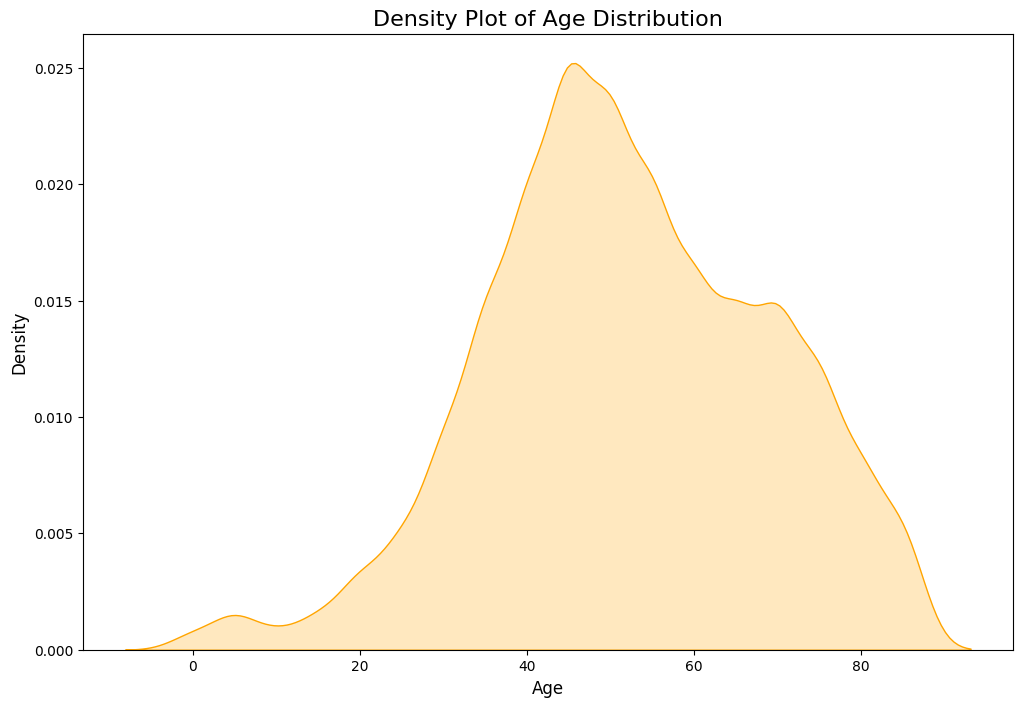

In [5]:
plt.figure(figsize=(12, 8))
sns.kdeplot(metadata_with_images['age'], fill=True, color='orange')
plt.title('Density Plot of Age Distribution', size=16)
plt.xlabel('Age', size=12)
plt.ylabel('Density', size=12)
plt.show()

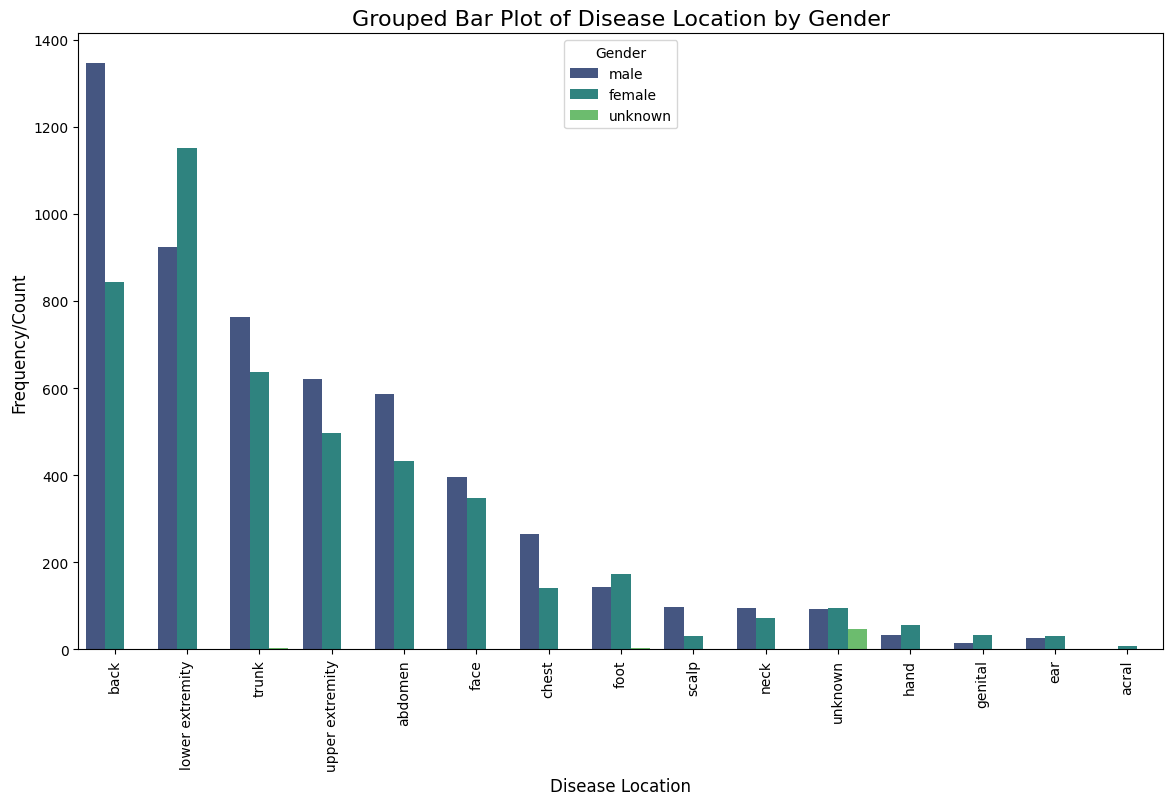

In [6]:
value = metadata_with_images[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1, 0], inplace=True)
temp = value.rename(columns={'localization': 'location', 0: 'count'})

plt.figure(figsize=(14, 8))
sns.barplot(x='location', y='count', hue='sex', data=temp, palette='viridis')
plt.title('Grouped Bar Plot of Disease Location by Gender', size=16)
plt.xlabel('Disease Location', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation=90)
plt.legend(title='Gender')
plt.show()

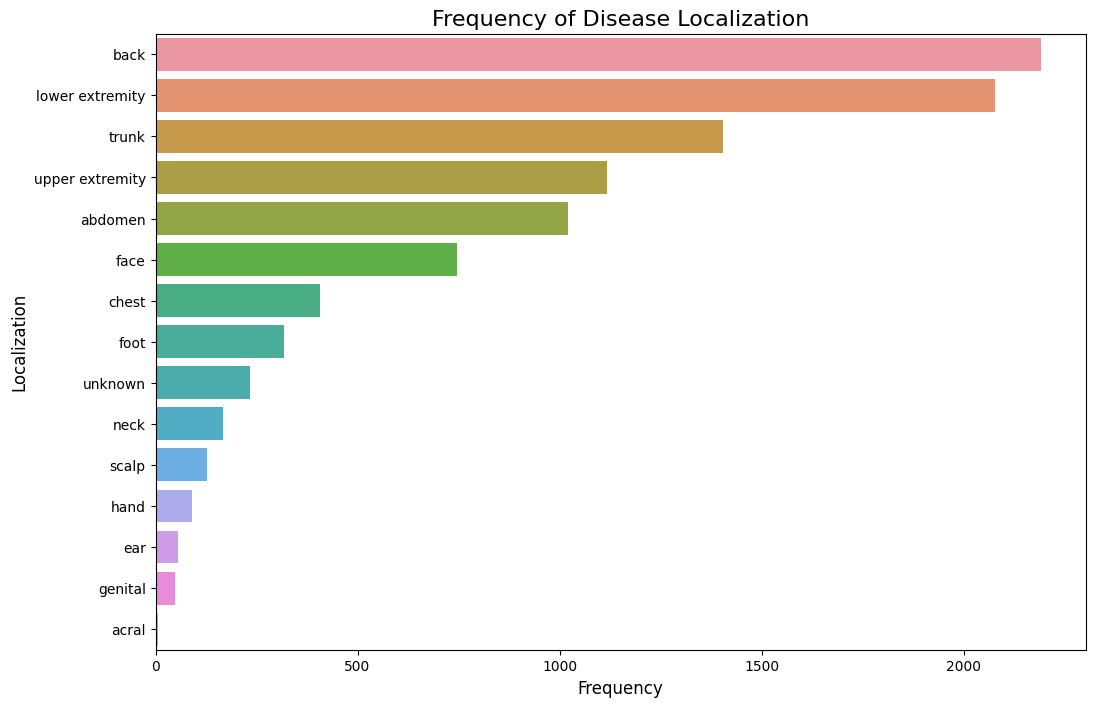

In [7]:
plt.figure(figsize=(12, 8))
sns.countplot(y='localization', data=metadata_with_images, order=metadata_with_images['localization'].value_counts().index)
plt.xlabel('Frequency', size=12)
plt.ylabel('Localization', size=12)
plt.title('Frequency of Disease Localization', size=16)
plt.show()

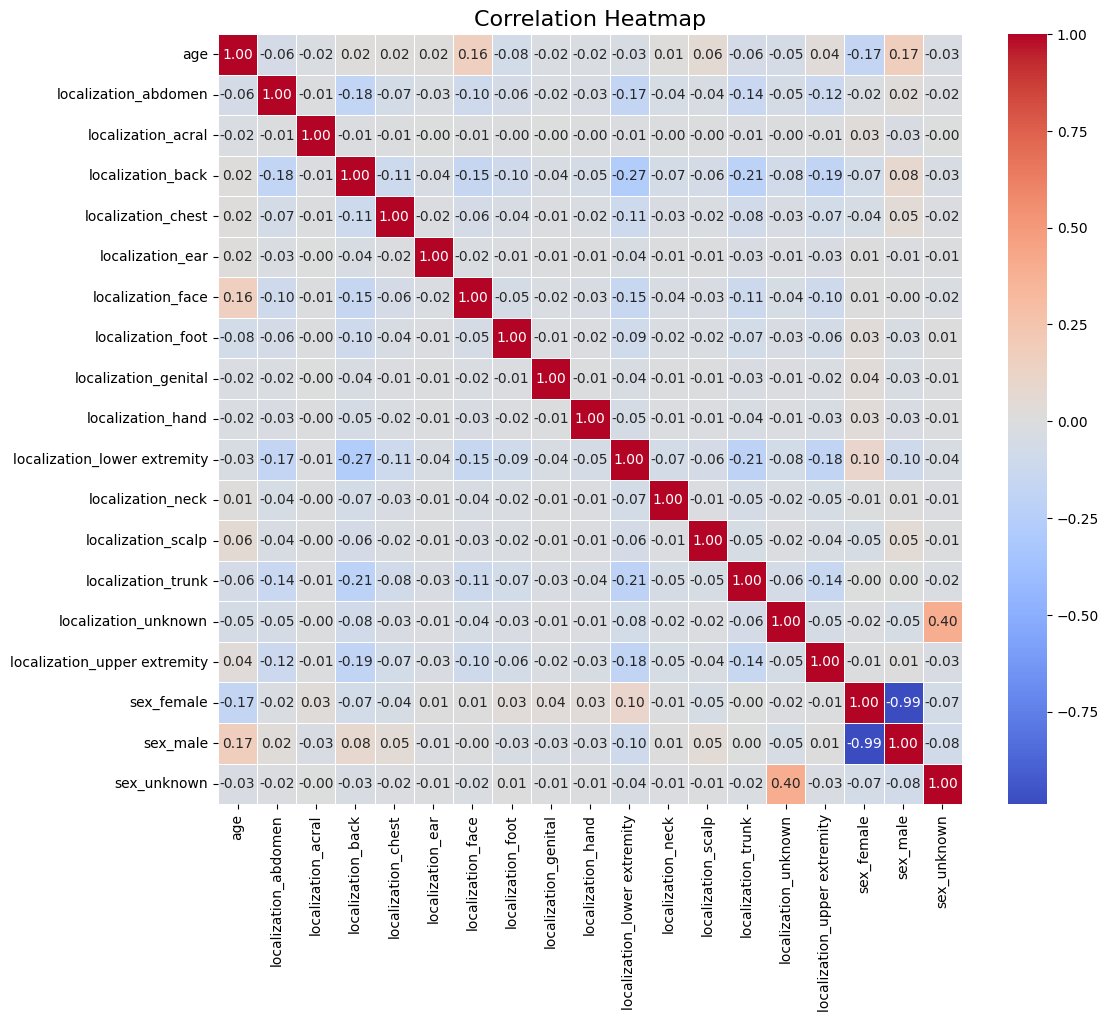

In [8]:
categorical_columns = ['localization', 'sex']
encoded_data = pd.get_dummies(metadata_with_images, columns=categorical_columns)

numerical_data = encoded_data[['age'] + [col for col in encoded_data.columns if col.startswith('localization_') or col.startswith('sex_')]]
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', size=16)
plt.show()

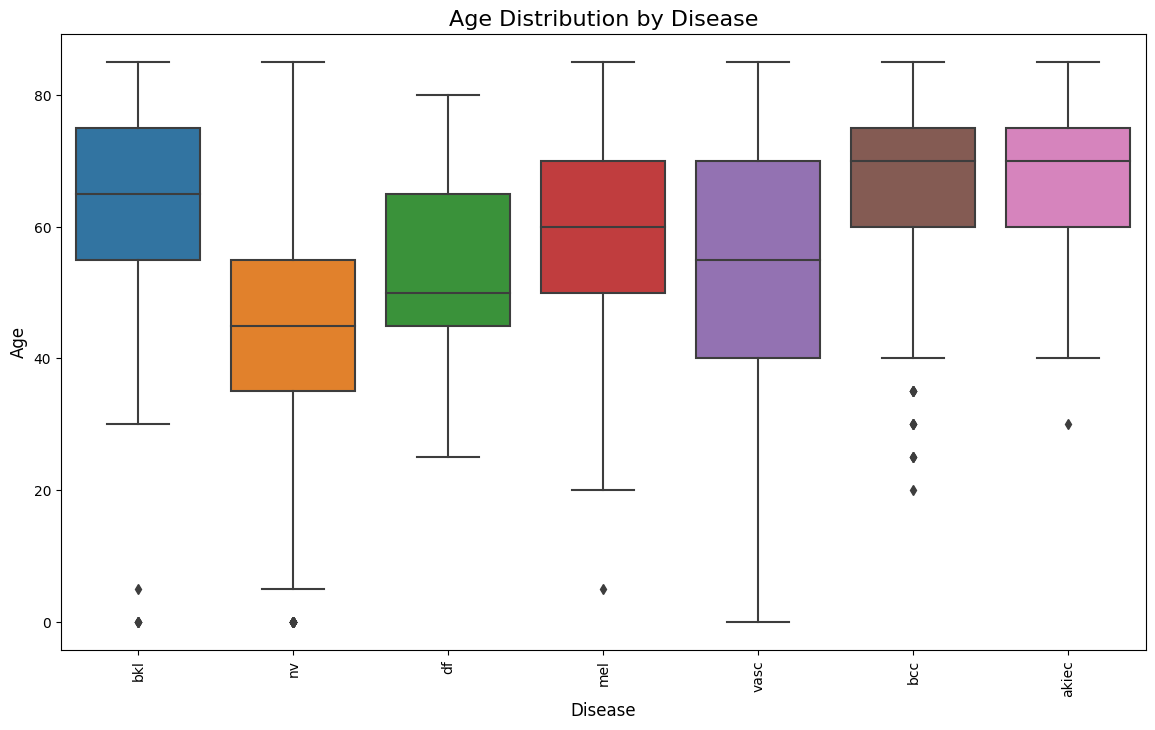

In [9]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='dx', y='age', data=metadata_with_images)
plt.xlabel('Disease', size=12)
plt.ylabel('Age', size=12)
plt.title('Age Distribution by Disease', size=16)
plt.xticks(rotation=90)
plt.show()

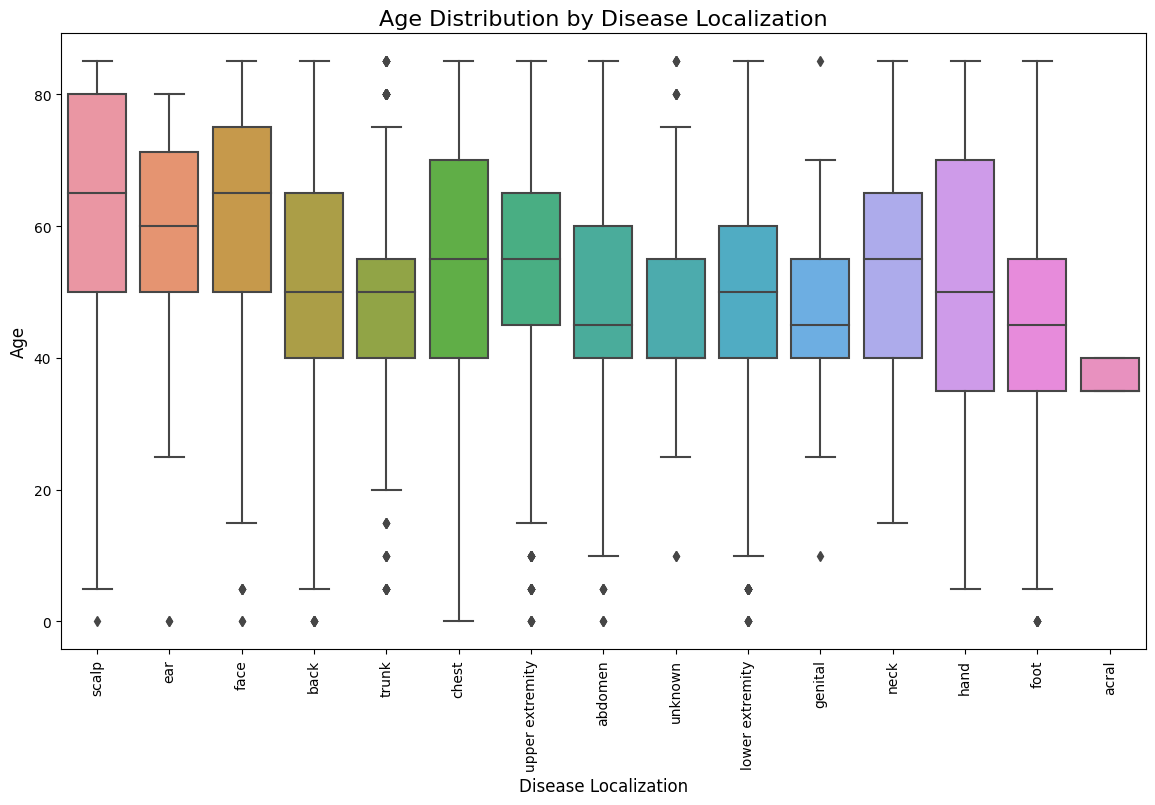

In [10]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='localization', y='age', data=metadata_with_images)
plt.xlabel('Disease Localization', size=12)
plt.ylabel('Age', size=12)
plt.title('Age Distribution by Disease Localization', size=16)
plt.xticks(rotation=90)
plt.show()

In [11]:
X = metadata_with_images.drop(columns=['dx'])
y = metadata_with_images['dx']

In [12]:
X

,age,sex,localization,r_0,r_1,r_2,r_3,r_4,r_5,r_6,...,b_774,b_775,b_776,b_777,b_778,b_779,b_780,b_781,b_782,b_783
0,80.0,male,scalp,192,195,197,202,208,209,208,...,185,193,198,193,183,151,135,139,165,177
1,80.0,male,scalp,27,69,122,158,172,175,177,...,188,173,191,180,141,99,81,54,29,26
2,80.0,male,scalp,192,200,202,206,207,209,202,...,157,155,175,154,172,175,150,144,141,118
3,80.0,male,scalp,40,95,143,171,178,190,193,...,145,123,137,147,147,115,74,37,17,15
4,75.0,male,ear,159,194,215,225,232,235,235,...,216,217,201,175,206,206,202,185,148,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,40.0,male,abdomen,183,183,184,188,183,205,219,...,204,207,219,222,206,181,182,187,186,189
10011,40.0,male,abdomen,3,41,119,130,131,136,149,...,179,166,163,163,162,136,128,76,22,2
10012,40.0,male,abdomen,134,166,175,185,195,209,212,...,216,213,208,197,178,200,191,178,153,148
10013,80.0,male,face,160,164,166,169,173,177,181,...,181,171,171,179,187,180,166,168,167,172


In [13]:
import pandas as pd

X = pd.DataFrame(X)

# Create a dictionary to map each category to an integer
label_mapping = {'male': 0, 'female': 1, 'unknown': 2}

# Apply the mapping to the 'sex' column
X['sex'] = X['sex'].map(label_mapping)

# Display the DataFrame with the new labels
X

,age,sex,localization,r_0,r_1,r_2,r_3,r_4,r_5,r_6,...,b_774,b_775,b_776,b_777,b_778,b_779,b_780,b_781,b_782,b_783
0,80.0,0,scalp,192,195,197,202,208,209,208,...,185,193,198,193,183,151,135,139,165,177
1,80.0,0,scalp,27,69,122,158,172,175,177,...,188,173,191,180,141,99,81,54,29,26
2,80.0,0,scalp,192,200,202,206,207,209,202,...,157,155,175,154,172,175,150,144,141,118
3,80.0,0,scalp,40,95,143,171,178,190,193,...,145,123,137,147,147,115,74,37,17,15
4,75.0,0,ear,159,194,215,225,232,235,235,...,216,217,201,175,206,206,202,185,148,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,40.0,0,abdomen,183,183,184,188,183,205,219,...,204,207,219,222,206,181,182,187,186,189
10011,40.0,0,abdomen,3,41,119,130,131,136,149,...,179,166,163,163,162,136,128,76,22,2
10012,40.0,0,abdomen,134,166,175,185,195,209,212,...,216,213,208,197,178,200,191,178,153,148
10013,80.0,0,face,160,164,166,169,173,177,181,...,181,171,171,179,187,180,166,168,167,172


In [14]:
X['localization'].unique()

array(['scalp', 'ear', 'face', 'back', 'trunk', 'chest',
       'upper extremity', 'abdomen', 'unknown', 'lower extremity',
       'genital', 'neck', 'hand', 'foot', 'acral'], dtype=object)

In [15]:
import pandas as pd

X = pd.DataFrame(X)

# Manually create a dictionary to map each category to a unique integer
localization_mapping = {
    'scalp': 0,
    'ear': 1,
    'face': 2,
    'back': 3,
    'trunk': 4,
    'chest': 5,
    'upper extremity': 6,
    'abdomen': 7,
    'unknown': 8,
    'lower extremity': 9,
    'genital': 10,
    'neck': 11,
    'hand': 12,
    'foot': 13,
    'acral': 14
}

# Apply the mapping to the 'localization' column
X['localization'] = X['localization'].map(localization_mapping)

# Display the DataFrame with the new labels
X

,age,sex,localization,r_0,r_1,r_2,r_3,r_4,r_5,r_6,...,b_774,b_775,b_776,b_777,b_778,b_779,b_780,b_781,b_782,b_783
0,80.0,0,0,192,195,197,202,208,209,208,...,185,193,198,193,183,151,135,139,165,177
1,80.0,0,0,27,69,122,158,172,175,177,...,188,173,191,180,141,99,81,54,29,26
2,80.0,0,0,192,200,202,206,207,209,202,...,157,155,175,154,172,175,150,144,141,118
3,80.0,0,0,40,95,143,171,178,190,193,...,145,123,137,147,147,115,74,37,17,15
4,75.0,0,1,159,194,215,225,232,235,235,...,216,217,201,175,206,206,202,185,148,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,40.0,0,7,183,183,184,188,183,205,219,...,204,207,219,222,206,181,182,187,186,189
10011,40.0,0,7,3,41,119,130,131,136,149,...,179,166,163,163,162,136,128,76,22,2
10012,40.0,0,7,134,166,175,185,195,209,212,...,216,213,208,197,178,200,191,178,153,148
10013,80.0,0,2,160,164,166,169,173,177,181,...,181,171,171,179,187,180,166,168,167,172


In [16]:
y = pd.DataFrame(y)

y['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [17]:
import pandas as pd

dx_mapping = {
    'bkl': 0,
    'nv': 1,
    'df': 2,
    'mel': 3,
    'vasc': 4,
    'bcc': 5,
    'akiec': 6
}

# Apply the mapping to the 'dx' column
y['dx'] = y['dx'].map(dx_mapping)

# Display the DataFrame with the new encoded column
y

,dx
0,0
1,0
2,0
3,0
4,0
...,...
10010,6
10011,6
10012,6
10013,6


In [18]:
oversample = RandomOverSampler()
X, y = oversample.fit_resample(X, y)
print(f"Balanced data shape: {X.shape} (features), {y.shape} (labels)")

Balanced data shape: (46935, 2355) (features), (46935, 1) (labels)


In [19]:
image_columns = [f'r_{i}' for i in range(784)] + [f'g_{i}' for i in range(784)] + [f'b_{i}' for i in range(784)]
X_images = X[image_columns].values

In [20]:
X_images

array([[192, 195, 197, ..., 139, 165, 177],
       [ 27,  69, 122, ...,  54,  29,  26],
       [192, 200, 202, ..., 144, 141, 118],
       ...,
       [183, 186, 190, ..., 149, 139, 131],
       [184, 187, 192, ..., 119, 123, 128],
       [196, 225, 223, ..., 164, 164, 159]], dtype=int64)

In [21]:
non_image_columns = ['sex', 'localization', 'age']
X_non_images = X[non_image_columns].values

In [22]:
X_non_images

array([[ 0.,  0., 80.],
       [ 0.,  0., 80.],
       [ 0.,  0., 80.],
       ...,
       [ 1., 12., 60.],
       [ 1.,  2., 60.],
       [ 0.,  6., 85.]])

In [23]:
X_non_images = np.nan_to_num(X_non_images, nan=-1)

In [24]:
X_images = np.array(X_images).reshape(-1, 28, 28, 3)
X_images = (X_images - np.mean(X_images)) / np.std(X_images)
print(f"Shape of X after reshaping and normalization: {X_images.shape}")

Shape of X after reshaping and normalization: (46935, 28, 28, 3)


In [25]:
X_train_images, X_test_images, X_train_non_images, X_test_non_images, Y_train, Y_test = train_test_split(
    X_images, X_non_images, y, test_size=0.2, random_state=1
)
print(f"Training data shape: {X_train_images.shape} (images), {X_train_non_images.shape} (non-images)")
print(f"Testing data shape: {X_test_images.shape} (images), {X_test_non_images.shape} (non-images)")

Training data shape: (37548, 28, 28, 3) (images), (37548, 3) (non-images)
Testing data shape: (9387, 28, 28, 3) (images), (9387, 3) (non-images)


In [26]:
image_input = layers.Input(shape=(28, 28, 3))
non_image_input = layers.Input(shape=(X_train_non_images.shape[1],))

In [27]:
non_image_input

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'input_2')>

In [28]:
conv = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(image_input)
conv = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(conv)
conv = layers.MaxPool2D(pool_size=(2, 2))(conv)

conv = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(conv)
conv = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(conv)
conv = layers.MaxPool2D(pool_size=(2, 2), padding='same')(conv)

attention = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(conv)
attention = layers.Add()([attention, conv])

flattened_conv = layers.Flatten()(attention)

In [29]:
concatenated = layers.Concatenate()([flattened_conv, non_image_input])

In [30]:
x = layers.Dense(128, activation='relu')(concatenated)
x = layers.Dropout(0.5)(x)

In [31]:
outputs = layers.Dense(len(np.unique(y)), activation='softmax')(x)

In [32]:
model = Model(inputs=[image_input, non_image_input], outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 16)           448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 26, 26, 32)           4640      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    [X_train_images, X_train_non_images],
    Y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
235/235 [==============================] - 35s 137ms/step - loss: 1.4198 - accuracy: 0.4595 - val_loss: 0.9540 - val_accuracy: 0.6450
Epoch 2/30
235/235 [==============================] - 31s 131ms/step - loss: 0.9413 - accuracy: 0.6460 - val_loss: 0.7165 - val_accuracy: 0.7370
Epoch 3/30
235/235 [==============================] - 31s 134ms/step - loss: 0.6842 - accuracy: 0.7420 - val_loss: 0.5089 - val_accuracy: 0.8032
Epoch 4/30
235/235 [==============================] - 33s 139ms/step - loss: 0.5278 - accuracy: 0.7981 - val_loss: 0.3696 - val_accuracy: 0.8593
Epoch 5/30
235/235 [==============================] - 32s 135ms/step - loss: 0.4070 - accuracy: 0.8425 - val_loss: 0.3019 - val_accuracy: 0.8795
Epoch 6/30
235/235 [==============================] - 31s 134ms/step - loss: 0.3281 - accuracy: 0.8731 - val_loss: 0.2511 - val_accuracy: 0.9019
Epoch 7/30
235/235 [==============================] - 34s 146ms/step - loss: 0.2773 - accuracy: 0.8918 - val_loss: 0.2304 - val_ac

In [34]:
test_loss, test_accuracy = model.evaluate([X_test_images, X_test_non_images], Y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Test loss: 0.1082
Test accuracy: 0.9742


In [35]:
Y_pred = np.argmax(model.predict([X_test_images, X_test_non_images]), axis=1)
print("\nClassification report:")
print(classification_report(Y_test, Y_pred))

294/294 [==============================] - 4s 12ms/step

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1352
           1       0.94      0.90      0.92      1374
           2       1.00      1.00      1.00      1307
           3       0.96      0.94      0.95      1271
           4       1.00      1.00      1.00      1360
           5       0.98      1.00      0.99      1340
           6       0.99      1.00      0.99      1383

    accuracy                           0.97      9387
   macro avg       0.97      0.97      0.97      9387
weighted avg       0.97      0.97      0.97      9387



<Figure size 1000x700 with 0 Axes>

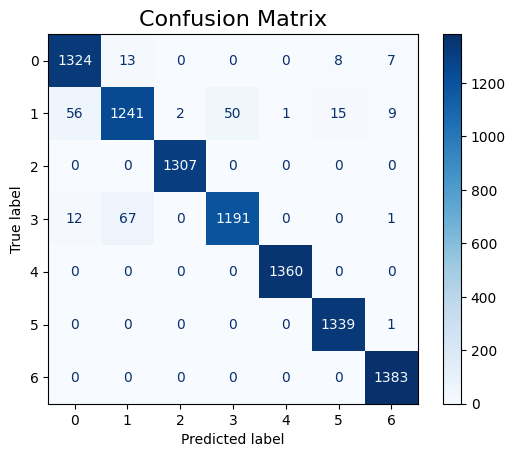

In [36]:
cm = confusion_matrix(Y_test, Y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(Y_test))
plt.figure(figsize=(10, 7))
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', size=16)
plt.show()

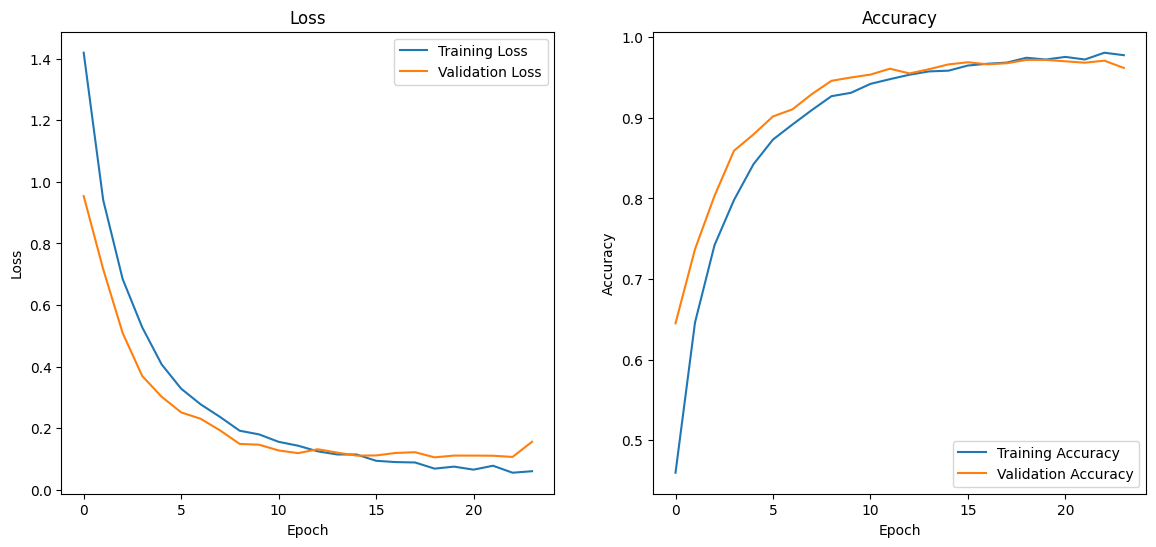

In [37]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
save_path = 'G:/My Drive/new/models/skin_lesion_classifier.h5'
model.save(save_path)

C:\Users\Ravi Galathiya\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
